In [ ]:
import json
import csv
import math
import os
import freud
# import freud.clusterd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.spatial.transform import Rotation as R
from joblib import Parallel, delayed

# Definitions

In [4]:
def min_image_convention(dx, box_size):
    """
    Apply the minimum image convention to get the shortest distance between two points in a periodic box.

    Parameters:
    dx (float): The distance between the two points.
    box_size (float): The size of the periodic box.

    Returns:
    float: The shortest distance between the two points after applying the minimum image convention.
    """
    dx -= np.round(dx / box_size) * box_size
    return dx

In [5]:
def calculate_velocities(positions, time_step, data_compression, box_size):
    """Calculates approximate velocities from position data, handling periodic boundaries.

    Args:
        positions: A NumPy array of shape (num_timesteps, num_particles, 3) containing particle positions (x, y, z).
        box_size:  The size of the periodic box in each dimension.

    Returns:
        A NumPy array of shape (num_timesteps - 1, num_particles, 3)
        containing the estimated velocities.
    """

    displacements = positions[1:] - positions[:-1]

    # Apply minimum image convention in each dimension
    displacements = min_image_convention(displacements, box_size)

    velocities = displacements / (time_step * data_compression)
    return velocities



In [6]:
def calculate_displacements(positions, box_size):
    """Calculates displacements from position data, handling periodic boundaries.

    Args:
        positions: A NumPy array of shape (num_timesteps, num_particles, 3) containing particle positions (x, y, z).
        box_size:  The size of the periodic box in each dimension.

    Returns:
        A NumPy array of shape (num_timesteps - 1, num_particles, 3)
        containing the estimated displacements.
    """

    displacements = positions[1:] - positions[:-1]

    # Apply minimum image convention in each dimension
    displacements = min_image_convention(displacements, box_size)

    return displacements

In [9]:
def calculate_cluster_angular_momentum(cluster_particles, velocities, center_of_mass,center_of_mass_velocity,box_size):
    """Calculates angular momentum for a cluster of particles.

    Args:
        cluster_particles:  A NumPy array of shape (num_cluster_particles, 3) containing
                            particle positions.
        velocities:         A NumPy array of shape (num_cluster_particles, 3) containing
                            particle velocities.
        center_of_mass:     A np array of shape (3,) containing the cluster's center of mass.

    Returns:
        A NumPy array of shape (3,) containing the cluster's angular momentum.
    """

    angular_momentum = np.zeros(3)
    for i, position in enumerate(cluster_particles):
        r_i = position - center_of_mass
        r_i = min_image_convention(r_i, box_size)  # Simplified
        p_i = velocities[i] - center_of_mass_velocity  # Adjusted here
        angular_momentum += np.cross(r_i, p_i)

    return angular_momentum

In [10]:
def calculate_cluster_angular_velocity(cluster_inertia, angular_momentum):
    """Calculates angular velocity from the inertia tensor and angular momentum.

    Args:
        cluster_inertia:  A (3, 3) NumPy array representing the cluster's inertia tensor.
        angular_momentum: A (3,) NumPy array representing the cluster's angular momentum.

    Returns:
        A (3,) NumPy array containing the cluster's angular velocity. 
    """

    inverted_inertia = np.linalg.inv(cluster_inertia)
    angular_velocity = np.dot(inverted_inertia, angular_momentum)
    return angular_velocity

In [7]:
def power_law(x, a, b):
    return a * np.array(x)**b

def exponential_fit(x, a, b):
    return np.exp(x*b)-1

def linear_fit(x, a, b):
    return a*np.array(x)+b

def exp_assimptotal_fit(x, k, c):
    return 1/c - np.exp(-np.array(x)/k)

# Data & Parameter Handling

In [ ]:
# path=r"Runs\Mid Density\CRun\B79S1.0D0.0M15"
path = r"C:\Users\alanb\Downloads\code_check\code_check\alan\configuration_data\unfold1.dat"

In [12]:
def save_param(path):
    csv_file_path=path+"/params.csv"
    # Open the CSV file
    with open(csv_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    return mydict

def load_data(path):
    with open(path+'/particle_positions.json', 'r') as file:
        data = json.load(file)
    return data

variable_dict=save_param(path)

r=float(variable_dict["sigma"])/2.0
numParticles=int(variable_dict["numParticles"])
boxSize=float(variable_dict["boxSize"])
timestep=float(variable_dict["timestep"])
dataCompression=int(variable_dict["dataCompression"])
theta=(float(variable_dict["theta"]))
DR=float(variable_dict["D_R"])

data = load_data(path)
particleData = np.array(data)
print(variable_dict)

cmap = plt.get_cmap('inferno')

{'comment': 'add comment', 'epsilon': '1', 'sigma': '1', 'numParticles': '625', 'boxSize': '79.077', 'temperature': '0.00497512', 'cutoff': '1.12246', 'my_gamma': '7.05346', 'timestep': '0.0141774', 'numSteps': '1000000', 'dataCompression': '1000', 'period': '100', 'NoOfPeriods': '1000', 'theta': '15', 'R_0': '1.5', 'D_R': '0.00564276', 'D_T': '0.000705346', 'Pe': '200', 'v_0': '0.141069', 'Omega': '0.352673'}


In [14]:
dataCompression=100
# total time 10000

In [15]:
def convert_dat_to_json(dat_file_path):
    data = []

    # Read the .dat file
    with open(dat_file_path, 'r') as file:
        lines = file.readlines()
        particles = []
        for line in lines:
            # Split the line into serial number, x coordinate, and y coordinate
            parts = line.strip().split('\t')
            x_coordinate = float(parts[1])
            y_coordinate = float(parts[2])
            # Append the coordinate to the particle list
            particles.append([x_coordinate, y_coordinate])
            # If the number of particles reaches 625, append to data and reset particles
            if len(particles) == 625:
                data.append(particles)
                particles = []

    # Append remaining particles if any
    if particles:
        # data.append(particles)
        print ("The last frame is incomplete")

    return data

# Example usage:
simulation_data = np.array(convert_dat_to_json(path))
simulation_data = np.concatenate((simulation_data, np.zeros((simulation_data.shape[0], simulation_data.shape[1], 1))), axis=2)
velocities = calculate_velocities(simulation_data, timestep, dataCompression, boxSize)

In [19]:
simulation_data = particleData[:, :, 2:4]
simulation_data = np.concatenate((simulation_data, np.zeros((simulation_data.shape[0], simulation_data.shape[1], 1))), axis=2)
velocities = calculate_velocities(simulation_data, timestep, dataCompression, boxSize)
displacemets = calculate_displacements(simulation_data, boxSize)

In [16]:
box = [boxSize, boxSize]
rcut = 1.2  # Your cutoff radius here
min_samples = 2  # Your minimum number of samples here

# Analysis

In [17]:
init_snapshot=simulation_data[10]
# The simulation box of the snapshot
boxi = freud.box.Box(Lx=box[0], Ly=box[1], is2D=True)

# This is the size of the bins for the distribution function
dr = 0.1
# The maximum radius to integrate to, this has to be smaller than half the width of the box.
rmax = 4

The bin with the highest value is 11


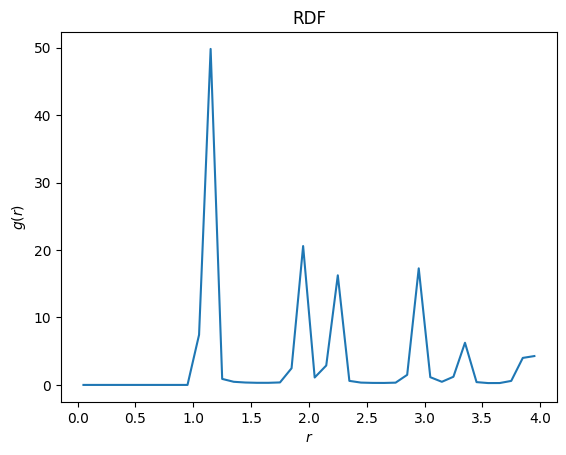

In [18]:
rdf = freud.density.RDF(bins=int(rmax/dr), r_max=rmax)
for frame in simulation_data:
    rdf.compute(system=(boxi, np.array(frame)), reset=False)
fig, ax = plt.subplots()
rdf.plot(ax=ax)
max_bin = np.argmax(rdf.rdf)
print("The bin with the highest value is", max_bin)

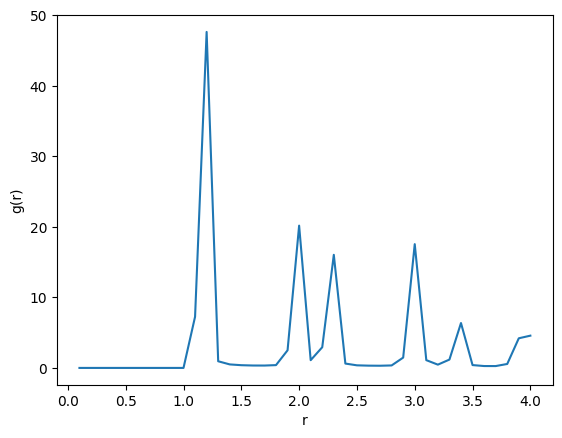

In [3]:
# read a dat file with 4 columns and plot the data takking the first column as x plot the other three as y
def plot_rdf_file(dat_file_path):
    data = np.loadtxt(dat_file_path)
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.show()

# Example usage:
plot_rdf_file(r"RMC\imsf_dilemma\configuration_data\rdf1.dat")

## Static Structure Factor

Now that we have nicely computed the radial distribution function we can convert it to the structure factor S(k) the equation for which is below for reference. Although computing the structure factor is supposed to be a Fourier transform, from Wikipedia we can invoke the isotropy of the liquid giving;

0.6739205557205085


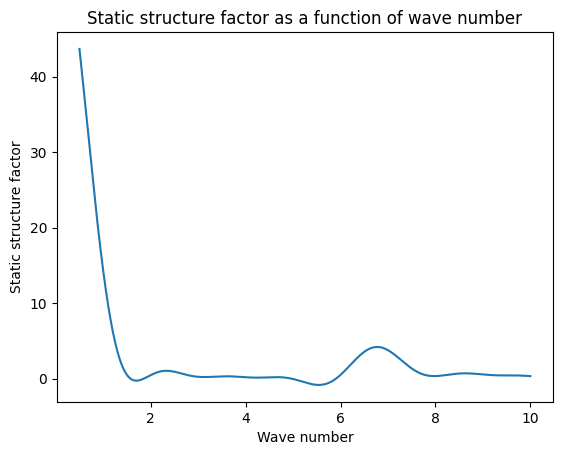

The first maxima is at 3.69748
The Bragg wave number is 0.6739205557205085


In [19]:
def static_structure_factor( rdf: freud.density.RDF, wave_number: float, num_particles: int):
    dr = rdf.bin_centers[1] - rdf.bin_centers[0]
    integral = dr * np.sum((rdf.rdf - 1) * rdf.bin_centers * np.sin(wave_number * rdf.bin_centers))
    density = num_particles / rdf.box.volume
    return 1 + 4 * np.pi * density / wave_number * integral

ssf = []
x = np.linspace(0.5, 10, 10000)
for value in x: ssf.append(static_structure_factor(rdf, value, numParticles))

# Find all peaks and Select the first peak
peaks, _ = find_peaks(ssf)

wave_number = x[peaks[0]]
k_bragg = np.pi / (2 * wave_number)
wave_number = 3.69748
# wave_number = np.pi / (2 *k_bragg)
print(k_bragg)

plt.plot(x, ssf)
plt.xlabel("Wave number")
plt.ylabel("Static structure factor")
plt.title("Static structure factor as a function of wave number")
plt.show()
print("The first maxima is at", wave_number)
print("The Bragg wave number is", k_bragg)

##  Intermediate Scattering Function

Covnert a wave number into a radially symmetric wave vector This calculates the values of cos and sin $\theta$ for `angular_resolution` values of $\theta$ between 0 and $2\pi$. The results of this function are cached, so these values only need to be computed a single time, the rest of the time they are just returned.

Calculate the intermediate scattering function for a specific wave-vector $$F(k, t) = \langle \cos( k [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{x}(0) - r_{x}(t)] ) \rangle$$
Where k is the value of `wave_number`, the values of the array `inital_position` are $r_{x(0)}$, while `current_position` is $r_{t}$. The number of values for the angle is give the `angular_resolution`. The values of initial_position and current_position are both expected to be a vector of shape N x 3 and the appropriate elements are extracted from it.

In [27]:
def create_wave_vector(wave_number: float, angular_resolution: int):
    angles = np.linspace(0, 2 * np.pi, num=angular_resolution, endpoint=False).reshape((-1, 1))
    wave_vector = np.concatenate([np.cos(angles), np.sin(angles)], axis=1)
    return wave_vector * wave_number


def intermediate_scattering_function( j: int, positions: np.ndarray, wave_vector:np.ndarray) -> float:
    displacement = positions[:-j,:,:2] - positions[j:, :,:2]
    # Reshape  to match the dimensions for dot product and Reshape the result back to the original shape
    displacement_xy = displacement.reshape(-1, 2)
    dot_product = np.dot(wave_vector, displacement_xy.T)
    dot_product = dot_product.reshape(positions.shape[0]-j, positions.shape[1], -1)
    print("The shape of the dot product is", dot_product.shape)
    return np.mean(np.mean(np.cos(dot_product),axis=2), axis=0).mean()

<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\i'
C:\Users\alanb\AppData\Local\Temp\ipykernel_63380\3606944982.py:8: SyntaxWarning: invalid escape sequence '\i'
  with open(r"RMC\imsf_dilemma\configuration_data" + '\imsf_dilemma.dat', 'w') as f:


Text(0.5, 1.0, 'Intermediate scattering function as a function of time')

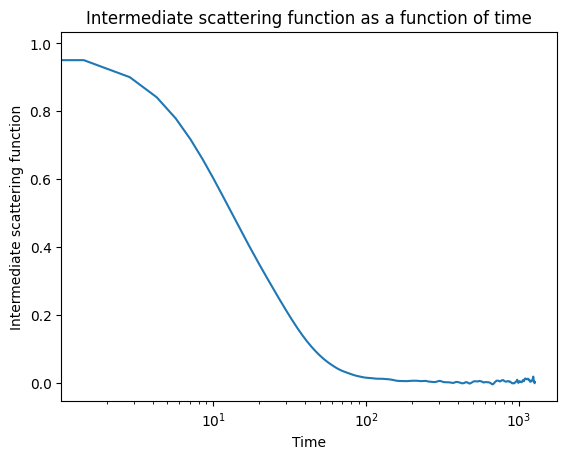

In [34]:
timesteps = [i*dataCompression*timestep for i in range(simulation_data.shape[0])]
frames = simulation_data
wave_vector = create_wave_vector(wave_number, 5)


scattering_values=Parallel(n_jobs=-1)(delayed(intermediate_scattering_function)(j, frames,  wave_vector) for j in range(1, len(frames)))

with open(r"RMC\imsf_dilemma\configuration_data" + '\imsf_dilemma.dat', 'w') as f:
    for i in range(len(timesteps[:-1])):
        f.write(f"{timesteps[i]:.4f}\t{scattering_values[i]:.4f}\n")
plt.plot(timesteps[:-1], scattering_values)
plt.xlabel("Time")
plt.xscale("log")
plt.ylabel("Intermediate scattering function")
plt.title("Intermediate scattering function as a function of time")

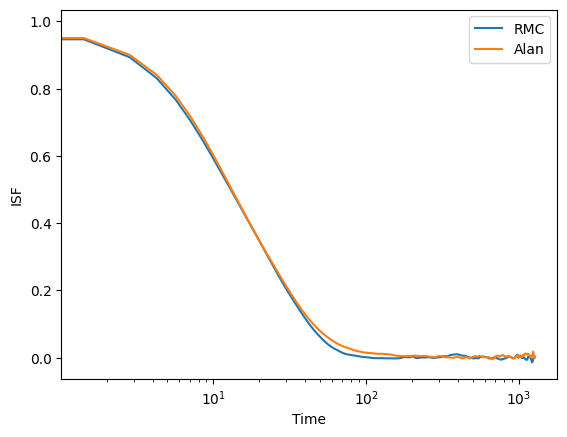

In [36]:
# read a dat file with 4 columns and plot the data takking the first column as x plot the other three as y
def plot_dat_file(dat_file_path):
    data = np.loadtxt(dat_file_path)
    x = data[:, 0]
    y = data[:, 1]
    z=scattering_values
    plt.plot(timesteps[:-1], y, label="RMC")
    plt.plot(timesteps[:-1], z, label="Alan")
    plt.xlabel("Time")
    plt.xscale("log")
    plt.ylabel("ISF")
    plt.legend()
    plt.show()

# Example usage:
plot_dat_file(r"RMC\imsf_dilemma\configuration_data\imsf1.dat")

# Rotational Correaltor

In [ ]:
def autoCorrelation_gap(j, direction_vector):
    d1 = direction_vector[:-j]
    d2 = direction_vector[j:]
    dot_product = np.sum(d1 * d2, axis=-1)
    sC1 = 0.5 * (3 * dot_product ** 2 - 1)
    return  np.mean(sC1)

def autoCorrelation(velocities, data_compression, time_step):
    # Normalize velocities to get unit orientation vectors
    norms = np.linalg.norm(velocities, axis=-1, keepdims=True)
    direction_vector = np.where(norms > 0, velocities / norms, np.zeros_like(velocities))
    size=velocities.shape[0]

    # averageAutoCorrelationPerGap=[autoCorrelation_gap(j, direction_vector) for j in range(1,size)]
    averageAutoCorrelationPerGap = Parallel(n_jobs=-1)(delayed(autoCorrelation_gap)(j, direction_vector) for j in tqdm(range(1, size)))

    x=[i*data_compression*time_step for i in range(1,size)]
    y=averageAutoCorrelationPerGap
    return x, y

x, y=autoCorrelation(velocities, dataCompression, timestep)
plt.plot(x, y)

In [ ]:
# Normalize velocities to get unit orientation vectors
norms = np.linalg.norm(velocities, axis=-1, keepdims=True)
unit_velocities = np.where(norms > 0, velocities / norms, np.zeros_like(velocities))

# Convert unit velocity vectors to quaternions by treating them as rotations from the x-axis.
def vectors_to_quaternions(dir_vectors):
    # Reshape dir_vectors to (N, 3) if necessary
    dir_vectors = dir_vectors.reshape(-1, 3)
    cross_products = np.cross(np.array([1, 0, 0]), dir_vectors)
    # Use Rotation.from_rotvec to create rotations from these cross products and convert to quaternions
    rotations = R.from_rotvec(cross_products)   
    return rotations.as_quat().reshape(-1, numParticles, 4)

# Compute rotational autocorrelation
rac = freud.order.RotationalAutocorrelation(1) # Hyperspherical harmonic order
orientations = vectors_to_quaternions(unit_velocities)
print (orientations[600])

# Compute order parameter for each gap and average it
gaps = range(1, simulation_data.shape[0])
avg_order_params = [rac.compute(orientations[:-gap].reshape(-1,  4), orientations[gap:].reshape(-1,  4)).order for gap in gaps]
plt.plot(gaps, avg_order_params)
plt.xlabel("Gap"); plt.ylabel("Average Rotational Autocorrelation"); plt.title("Average Rotational Autocorrelation of Velocity-Based Orientations")
plt.show()

In [ ]:
# read a dat file with 4 columns and plot the data takking the first column as x plot the other three as y
def plot_dat_file(dat_file_path):
    data = np.loadtxt(dat_file_path)
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    # b = data[:, 3]
    plt.plot(x, y)
    plt.plot(x, z)
    plt.xlabel("Time")
    # plt.xscale("log")
    plt.ylabel("Intermediate scattering function")
    plt.show()

# Example usage:
plot_dat_file(r"RMC/imsf_dilemma/configuration_data/rotational_coupling.dat")

In [ ]:
timesteps = simulation_data.shape[0]
positions = simulation_data
order_params = []

# Normalize velocities to get unit orientation vectors
norms = np.linalg.norm(velocities, axis=-1, keepdims=True)
unit_velocities = np.where(norms > 0, velocities / norms, np.zeros_like(velocities))

# Convert unit velocity vectors to quaternions by treating them as rotations from the x-axis.
def vectors_to_quaternions(dir_vectors):
    quaternions = np.zeros((timesteps, numParticles, 4))  # quaternions placeholder
    for t in range(1,timesteps-1):
        for i in range(numParticles):
            direction = dir_vectors[t, i]
            rotation = R.from_rotvec(np.cross([1, 0, 0], direction))  # Rotate from x-axis
            quaternions[t, i] = rotation.as_quat()
    return quaternions

orientations = vectors_to_quaternions(unit_velocities)

# Compute rotational autocorrelation
rac = freud.order.RotationalAutocorrelation(2) # Hyperspherical harmonic order

# Compute order parameter at each timestep
for j in range(1, len(orientations)):
    rac.compute(orientations[0], orientations[t])
    order_params.append(rac.order)  # Get scalar order parameter

plt.plot(order_params)
plt.xlabel("Time Step")
plt.ylabel("Rotational Autocorrelation")
plt.title("Rotational Autocorrelation of Velocity-Based Orientations")
plt.show()

# Displacement Corelation
its displacement $u_i$ over some interval of time $\Delta t$, starting from a time $t$ :
$$
u_i(t, \Delta t)=\left|\mathbf{r}_i(t+\Delta t)-\mathbf{r}_i(t)\right|
$$

The general question of whether there exist dynamically correlated regions in a glass-forming liquid can be addressed using these individual particle displacements. Specifically, we test if the values of $u$ for two distinct particles are, on average, correlated if the two particles are initially close in space. To quantify this, we modify the definition of $g(r)$ so that the contribution of each particle to the correlation function is weighted by its subsequent displacement over a time interval $\Delta t$. That is, we define a "displacement-displacement" correlation function,
$$
g^{u u}(r, \Delta t)=\frac{1}{\langle u(\Delta t)\rangle^2 \rho N}\left\langle\sum_{i=1}^N \sum_{\substack{j=1 \\ j \neq i}}^N u_i(0, \Delta t) u_j(0, \Delta t) \delta\left(\mathbf{r}+\mathbf{r}_i(0)-\mathbf{r}_j(0)\right)\right\rangle
$$

In [ ]:
#create a 100 x 100 grid 0 metric called g_uu
positions = simulation_data[1:100]
g_uu = np.zeros((positions.shape[0], positions.shape[0]),dtype=np.float64)
#print curent time
print("Current time: ")
# Calculate displacements over a time gap Δt
def compute_displacement(positions, delta_t, box_size):
    displacements = min_image_convention(positions[delta_t:] - positions[:-delta_t], box_size)
    displacements = np.linalg.norm(displacements, axis=-1)
    return displacements
def compute_distance_grid(positions, box_size):
    diffs = positions[:, :, np.newaxis, :] - positions[:, np.newaxis, :, :]
    diffs = diffs - box_size * np.round(diffs / box_size)
    distance_grid = np.linalg.norm(diffs, axis=-1)
    return distance_grid
distance_grid=compute_distance_grid(positions, boxSize)
print(distance_grid.shape)
def calculate_guu(positions, r_dis, box_size, delta_t):
    # Calculate the displacements
    displacements = compute_displacement(positions, delta_t, box_size)
    normalization_constant = np.mean(displacements)**2
    #extract the indexes in distance grid where the distance is equal to r_dis
    indexes = np.where(np.isclose(distance_grid[:-delta_t], r_dis, atol=1e-1))
    if indexes[0].size == 0: g_rt= 0.0  # or np.nan
    else:g_rt=np.mean(displacements[indexes[0], indexes[1]]*displacements[indexes[0], indexes[2]])/normalization_constant
    return g_rt
#calculate g_uu for a range of r_dis values and delta_t values
r_dis = np.linspace(0, 10, positions.shape[0])
delta_t = np.arange(1, positions.shape[0])
def calculate_guu_parallel(dt, r_dis, positions, box_size):
    return [calculate_guu(positions, r, box_size, dt) for r in r_dis]

results = Parallel(n_jobs=-1)(delayed(calculate_guu_parallel)(dt, r_dis, positions, boxSize) for dt in tqdm(delta_t))

# Convert results to a numpy array
g_uu = np.array(results)


Current time: 
(99, 625, 625)


100%|██████████| 98/98 [08:38<00:00,  5.29s/it] 


In [ ]:
# # plot g_uu
# plt.imshow(g_uu, extent=(r_dis[0], r_dis[-1], delta_t[-1], delta_t[0]), aspect='auto')
# plt.colorbar(label='g_uu')
plt.plot(r_dis, g_uu[5, :])
plt.xlabel('r_dis')
plt.ylabel('delta_t')
plt.title('Velocity autocorrelation function')
plt.show()

In [ ]:
def compute_displacement(positions, delta_t):
    return np.linalg.norm(positions[delta_t:] - positions[:-delta_t], axis=-1)

def g_uu_gap(delta_t, positions, max_r, dr):
    displacements = compute_displacement(positions, delta_t)
    N = positions.shape[1]

    # Average displacement for normalization
    mean_u2 = np.mean(displacements ** 2)

    # Initialize correlation histogram
    r_bins = np.arange(0, max_r, dr)
    g_uu = np.zeros_like(r_bins, dtype=np.float64)

    # Iterate over all particle pairs
    for t in range(positions.shape[0] - delta_t):
        pos_t = positions[t]
        pos_t_dt = positions[t + delta_t]
        d_t = displacements[t]

        # Pairwise distances at time t
        pairwise_diff = pos_t[:, np.newaxis, :] - pos_t
        pairwise_dist = np.linalg.norm(pairwise_diff, axis=-1)

        # Pairwise product of displacements and Exclude self-correlation (i != j)
        u_i_u_j = d_t[:, np.newaxis] * d_t
        np.fill_diagonal(u_i_u_j, 0)

        # Bin the results
        bin_indices = (pairwise_dist / dr).astype(int)
        valid_bins = (bin_indices < len(r_bins))
        np.add.at(g_uu, bin_indices[valid_bins], u_i_u_j[valid_bins])

    # Normalize
    rho = N / (np.max(positions) ** 2)  # Density for a 2D system
    g_uu /= (mean_u2 * rho * N * (positions.shape[0] - delta_t))

    return r_bins, g_uu

def g_uu(positions, delta_t, max_r, dr):
    results = Parallel(n_jobs=-1)( delayed(g_uu_gap)(delta_t, positions, max_r, dr) for delta_t in tqdm(range(1, delta_t + 1)))
    # Aggregate results across all time gaps
    r_bins = results[0][0]
    g_uu_values = np.mean([res[1] for res in results], axis=0)

    return r_bins, g_uu_values

# Example usage:
# positions: (timesteps, N_particles, 2)
# delta_t: maximum time interval to compute correlation
# max_r: maximum spatial separation to consider
# dr: bin width
r_bins, g_uu_values = g_uu(positions, delta_t=50, max_r=10.0, dr=0.1)


100%|██████████| 50/50 [00:08<00:00,  5.74it/s] 


In [ ]:
#plot r_bins and g_uu_values
plt.plot(r_bins, g_uu_values)

# Self-overlap function
$Q(t)=\left\langle\frac{1}{N} \sum_{i=1}^N W\left(a-\left|\mathbf{r}_i(t)-\mathbf{r}_i(0)\right|\right)\right\rangle$

Four-point dynamical susceptibility. The four-point dynamical susceptibility, $\chi_4(t)$, is defined in terms of the fluctuations of the two-point overlap correlation function as
$$
\chi_4(t)=N\left[\left\langle\tilde{Q}^2(t)\right\rangle-\langle\tilde{Q}(t)\rangle^2\right]
$$

100%|██████████| 998/998 [00:07<00:00, 127.71it/s]


The four-point dynamical susceptibility is 0.00010491075493170349


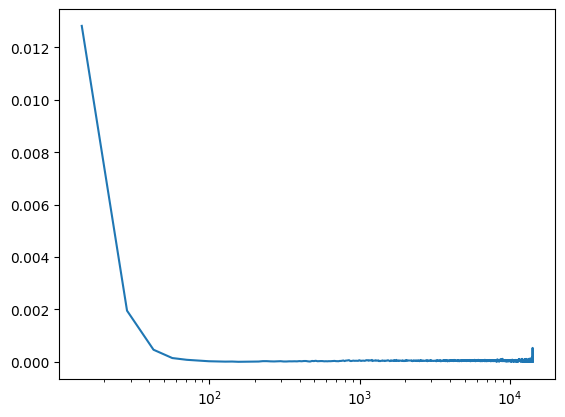

In [23]:
def avg_displacement(j, positions,box_size):
    d1 = positions[:-j]
    d2 = positions[j:]
    displacemet = np.linalg.norm(min_image_convention(d2 - d1,box_size), axis=-1)  # Compute the magnitude of the difference
    heaviside = np.heaviside(0.3 - displacemet, 0)
    # return  np.mean(np.mean(heaviside,axis=-2))        #TODO - we averaged over everything all at once instead of particles first the time
    return  np.mean(heaviside)        #TODO - we averaged over everything all at once instead of particles first the time


def self_overlap(positions, data_compression, time_step):
    size=velocities.shape[0]
    Q = Parallel(n_jobs=-1)(delayed(avg_displacement)(j, positions,boxSize) for j in tqdm(range(1, size)))
    t=[i*data_compression*time_step for i in range(1,size)]
    return t, Q

x, y=self_overlap(simulation_data, dataCompression, timestep)
#x scale should be log
plt.xscale("log")
plt.plot(x, y)
fourpoint_dynamical_susceptibility = numParticles*np.std(y)**2
print("The four-point dynamical susceptibility is", fourpoint_dynamical_susceptibility)

## MSD

In [17]:
def compute_msd(simulation_data, box_size):
    positions = simulation_data

    # Initialize a freud box object, Create a freud MSD object and Unwrap the positions
    box = freud.box.Box(Lx=box_size, Ly=box_size, is2D=True)
    msd = freud.msd.MSD(box)
    unwrapped_positions = np.unwrap(positions, axis=0)

    # Compute the MSD for the unwrapped positions provided and Retrieve the mean squared displacement
    msd.compute(unwrapped_positions)
    mean_squared_displacement = msd.msd

    return mean_squared_displacement

# msd_result = compute_msd(simulation_data, boxSize, timestep, dataCompression)
# np.savetxt(path+'/msd_result.txt', msd_result, 1)


In [12]:
def plot_msd(msd_result,time_step, data_compression):
    # Create a time array based on the number of frames
    time = np.arange(len(msd_result))
    time=[i*data_compression*time_step*DR for i in range(len(msd_result))]
    # Plot the MSD
    plt.plot(time, msd_result, marker='o', linestyle='-', markersize=2)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Time')
    plt.ylabel('Mean Squared Displacement')
    plt.title('Mean Squared Displacement vs Time')
    plt.grid(True)
    plt.show()

# plot_msd(msd_result, timestep, dataCompression)


## Hexactic Order Parameter

In [ ]:
op = freud.order.Hexatic(k=6)
op.compute(system= ({'Lx': boxSize, 'Ly': boxSize, 'dimensions': 2}, simulation_data[-1] ))

In [35]:
def temporal_HOP_distribution(simulation_data, data_compression, time_step):
    hexatic_values = []
    time=[i*data_compression*time_step for i in range(len(simulation_data))]

    for frame in simulation_data:
        op.compute(system=(box, frame))
        hexatic_values.append(np.mean(np.abs(op.particle_order)))

    return hexatic_values, time

In [ ]:
hexatic_values, time = temporal_HOP_distribution(simulation_data, dataCompression, timestep)
# Plot the value of the order parameter.
plt.plot(time, hexatic_values, '*', color="black", markersize=2)
# Customize tick marks for both major and minor ticks
plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
plt.minorticks_on()

plt.xlabel('t', fontsize=14)
plt.xscale('log')
plt.ylabel('$\\Psi_6$', fontsize=14)
plt.ylim(0, 1)
plt.title('Average Hexactic Order parameter, Theta =' + str(theta))
plt.savefig(path+'/order_parameter.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')

## Cluster Analysis

In [18]:
def frame_cluster_counter(coordinates, rcut, min_samples):
    # Initialize Cluster object
    cluster = freud.cluster.Cluster()
    cluster.compute(system=(box, coordinates), neighbors={'r_max': rcut})
    cluster_idx = cluster.cluster_idx
    frame_cluster_outdata = defaultdict(int)
    cluster_idx_with_noise=np.array(cluster_idx)
    for label in set(cluster_idx):
        frame_cluster_outdata[np.sum(cluster_idx == label)] += 1
        #if label is unique, then replace it by 625
        if np.sum(cluster_idx == label) == 1: cluster_idx_with_noise[cluster_idx == label] = 625
    return frame_cluster_outdata, cluster_idx_with_noise, cluster_idx

In [24]:
frame_cluster_size_count,_, _=frame_cluster_counter(simulation_data[-1], rcut, 5)
# Print the database listing the cluster size and the number of clusters with that size
print("Cluster Size\tNumber of Clusters\n-----------------------------------")
for cluster_size, count in sorted(frame_cluster_size_count.items()): print(f"{cluster_size}\t\t{count}")

Cluster Size	Number of Clusters
-----------------------------------
47		1
578		1


In [30]:
def spatial_clusteral_distribution(particle_data, time_step, data_compression, rcut, min_samples):
    accumulated_cluster_size_count = defaultdict(int)
    positions = particle_data

    for frame in positions:
        coordinates = frame
        frame_cluster_size_count, _, _ = frame_cluster_counter(coordinates, rcut, min_samples)

        for cluster_size, count in frame_cluster_size_count.items(): accumulated_cluster_size_count[cluster_size] += count
    return accumulated_cluster_size_count
accumulated_cluster_size_count= spatial_clusteral_distribution(simulation_data[:], timestep, dataCompression, rcut, min_samples)

print(accumulated_cluster_size_count)

defaultdict(<class 'int'>, {87: 5323, 86: 859, 70: 29103, 56: 3325, 41: 4867, 38: 742, 29: 742, 28: 2453, 27: 1574, 26: 2646, 23: 4968, 21: 4493, 20: 283, 19: 823, 12: 560, 11: 2608, 10: 936, 7: 341, 3: 303, 2: 692, 1: 2782, 8: 231, 5: 292, 9: 1620, 4: 451, 39: 431, 6: 977, 14: 2090, 16: 24, 17: 542, 18: 598, 22: 3639, 69: 26, 40: 14, 45: 25, 46: 20, 42: 3, 43: 22901, 44: 22, 47: 76881, 67: 14297, 48: 1815, 49: 1189, 50: 10, 53: 1318, 52: 375, 114: 2336, 66: 43, 13: 822, 113: 1, 83: 466, 31: 15, 89: 163, 25: 70, 88: 147, 95: 5, 15: 115, 37: 19, 33: 6356, 58: 1326, 59: 1, 60: 711, 24: 22061, 115: 12403, 61: 27, 62: 2566, 71: 1, 77: 1469, 75: 9, 76: 2, 91: 215, 72: 63, 111: 29862, 73: 3229, 110: 27, 94: 2478, 32: 7954, 30: 4, 92: 1, 129: 921, 68: 2179, 128: 1, 51: 3, 63: 6, 55: 23, 64: 947, 82: 4509, 167: 4759, 166: 4, 65: 8, 81: 1385, 78: 51, 79: 24, 215: 4665, 214: 5, 34: 2466, 36: 1089, 298: 7389, 216: 79, 297: 5, 330: 5695, 400: 3585, 57: 19, 54: 18, 447: 4314, 558: 3432, 577: 1519, 

In [ ]:
#print  accumulated_cluster_size_count sorted by its key
print("Cluster Size\tNumber of Clusters\n-----------------------------------")
for cluster_size, count in sorted(accumulated_cluster_size_count.items()): print(f"{cluster_size}\t\t{count}")

In [ ]:
def plot_spatial_cluster_distrribution(particle_data, accumulated_cluster_size_count, theta, folder_path):
    # average_cluster_size_count = {cluster_size: count/size for cluster_size, count in accumulated_cluster_size_count.items()}
    bin_size = 10
    positions = particle_data
    num_bins = positions.shape[1] // bin_size

    # crerate a list which stores the "cluster size" n times where  n is the number of clusters of that size
    cluster_size_list = [cluster_size for cluster_size, count in accumulated_cluster_size_count.items() for _ in range(count)]
    #sort cluster_size_list
    cluster_size_list.sort()
    # remove firsdt 10% of the data
    # cluster_size_list=cluster_size_list[int(len(cluster_size_list)*0.8):]
    # # plot average_cluster_size_count as a histogram
    plt.hist(cluster_size_list, bins=num_bins, density=True)
    # plt.bar(average_cluster_size_count.keys(), average_cluster_size_count.values())
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Clusters throughout simulation')
    # plt.xlim(100, 600)
    
    plt.title(f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.grid()
    # plt.savefig(os.path.join(folder_path, 'spatial_clusteral_distribution.png'))
    plt.show()
    plt.close()
    
plot_spatial_cluster_distrribution(simulation_data[:], accumulated_cluster_size_count, theta, path)

In [42]:
#find the avergae value of accumulated_cluster_size_count by multiplying the key with the value and dividing by the total number of frames
alist = [count for cluster_size, count in accumulated_cluster_size_count.items() if cluster_size>=1]
a=np.sum(alist)
blist=[cluster_size * count for cluster_size, count in accumulated_cluster_size_count.items() if cluster_size>=1]
b=np.sum(blist)
print(b/a)


143.96793546141404


In [15]:
def temporal_clusteral_distribution(particle_data, time_step, data_compression, rcut, min_samples):
    average_cluster_size = []
    time = []
    positions = particle_data

    # Iterate over frames
    for frame in positions:
        coordinates = frame

        # Compute cluster size count for the frame & Calculate total number of clusters
        frame_cluster_size_count, _, _ = frame_cluster_counter(coordinates, rcut, min_samples)
        total_no_of_clusters = np.sum(list(frame_cluster_size_count.values()))
        total_no_of_particles_in_cluster = np.sum([k*v for k, v in frame_cluster_size_count.items()])
        # Calculate average cluster size
        if total_no_of_clusters > 0:
            average_size = total_no_of_particles_in_cluster / total_no_of_clusters
            average_cluster_size.append(average_size)
        else: average_cluster_size.append(0)

        time = [i*data_compression*time_step for i in range(particle_data.shape[0])]
    return time, average_cluster_size

In [ ]:
time, avg_cluster_size = temporal_clusteral_distribution(simulation_data, timestep, dataCompression, rcut, min_samples)

# Plot
plt.scatter(time, avg_cluster_size, color='black', s=2.0)
# plt.plot(time, avg_cluster_size, color='black')
plt.xlabel('Time')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylabel('Average Cluster Size')
plt.title('Average Cluster Size as a Function of Time, Theta = ' + str(theta))
plt.show()

## Rotational Analysis

In [16]:
def frame_rotaional_observable_spiter(coordinates, rcut, min_samples, velocities,box_size):
    # Initialize Cluster object
    cluster = freud.cluster.Cluster() 
    cluster.compute(system=(box, coordinates), neighbors={'r_max': rcut})

    # Initialize ClusterProperties object
    cprops = freud.cluster.ClusterProperties()
    cprops.compute(system=(box, coordinates), cluster_idx=cluster.cluster_idx)

    hop = freud.order.Hexatic(k=6)
    hop.compute((box, coordinates))

    frame_cluster_ang_momentum = {}  # To store angular momenta
    frame_cluster_ang_velocity = {}  # To store angular velocities
    _, cluster_idx_with_noise, cluster_idx=frame_cluster_counter(coordinates, rcut, min_samples)
    for label in set(cluster_idx_with_noise):
        if label != 625: 
            cluster_particles = coordinates[cluster_idx_with_noise == label]
            cluster_vels = velocities[cluster_idx_with_noise == label]  # Extract velocities

            # if np.mean(np.absolute(hop.particle_order[cluster.cluster_idx == label])) >= 0.0:  # Threshold check

            center_of_mass = cprops.centers_of_mass[label]
            center_of_mass_velocity = np.mean(velocities[cluster.cluster_idx == label], axis=0)

            ang_momentum = calculate_cluster_angular_momentum(cluster_particles, cluster_vels, center_of_mass, center_of_mass_velocity, box_size)
            frame_cluster_ang_momentum[label] = ang_momentum

            # Getting the inertia tensor from freud
            # inertia_tensor = cprops.inertia_tensors[label]
            # angular_velocity = calculate_cluster_angular_velocity(inertia_tensor, ang_momentum)
            # frame_cluster_ang_velocity[label] = angular_velocity

    return frame_cluster_ang_velocity, frame_cluster_ang_momentum

In [17]:
def temporal_AM_distribution(simulation_data, velocities, rcut, min_samples, box_size):
    all_angular_momenta = []  # To store data over all frames
    time = []
    for i in tqdm(range(len(simulation_data)-1)):
        coordinates = simulation_data[i]
        vels = velocities[i]  # Get velocities for the corresponding frame

        _, cluster_ang_momenta = frame_rotaional_observable_spiter(coordinates, rcut, min_samples, vels, box_size)

        # Calculate average angular momentum magnitude for this frame
        # avg_ang_momentum = [np.linalg.norm(am) for am in cluster_ang_momenta.values()]
        # all_angular_momenta.extend(avg_ang_momentum)
        # time.extend(len(avg_ang_momentum) * [dataCompression * timestep * i* DR])
        avg_ang_momentum = np.mean([np.linalg.norm(am) for am in cluster_ang_momenta.values()])
        all_angular_momenta.append(avg_ang_momentum)
        time.append(dataCompression * timestep * i)
    return all_angular_momenta, time


In [ ]:
all_angular_momenta, time=temporal_AM_distribution(simulation_data, velocities, rcut, min_samples, boxSize)
plt.figure(figsize=(8, 6))   # Adjust figure size as needed
plt.scatter(time, all_angular_momenta, s=1, c='black')
plt.xlabel("Time")
plt.ylabel("Average Angular Momentum")
plt.title("Average Angular Momentum over Time, Theta = " + str(theta))
plt.grid(True)
plt.savefig(path+'/angular_momentum.png')
plt.show()

# Multi Plotter

In [ ]:
parentFolder = r"Runs\Mid Density\CRun"
filePaths = [f.path+"/" for f in os.scandir(parentFolder) if f.is_dir()]
l=70
h=40

## HOP

In [ ]:
def simHOP(filePaths):
    all_HOP_list = []
    all_time_list = []

    for i, file_path in enumerate(tqdm(filePaths)):
        if i%3!=0: continue

        data = load_data(file_path)
        particleData = np.array(data)

        variable_dict=save_param(file_path)
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])

        simulation_data = particleData[:, :, 2:4]
        simulation_data = np.concatenate((simulation_data, np.zeros((simulation_data.shape[0], simulation_data.shape[1], 1))), axis=2)

        all_HOP, time=temporal_HOP_distribution(simulation_data, dataCompression, timestep)
        all_HOP_list.append(all_HOP)
        all_time_list.append(time)
    return all_HOP_list, all_time_list
all_HOP_list,all_time_list=simHOP(filePaths)

0it [00:00, ?it/s]C:\Users\alanb\AppData\Local\Temp\ipykernel_26900\1650313332.py:2: RuntimeWarning: divide by zero encountered in power
  return a * np.array(x)**b
48it [00:06,  7.23it/s]


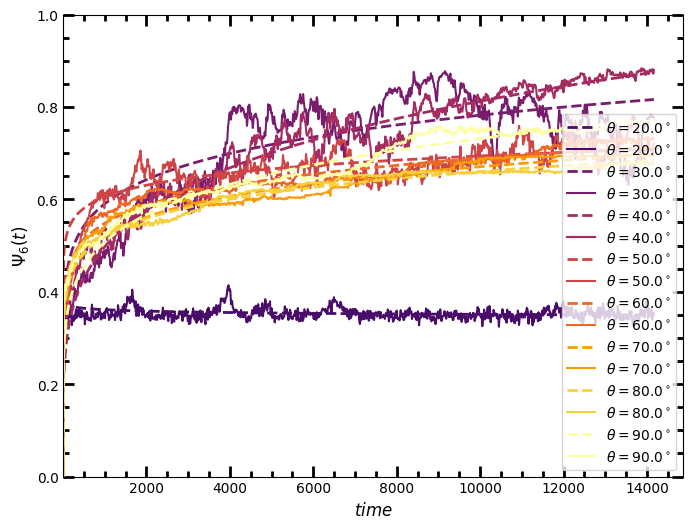

In [27]:
plt.figure(figsize=(8, 6))   # Adjust figure size as needed
for j, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])

    if j%3!=0 or theta%10!=0: continue
    i=math.floor(j/3)

    popt, pcov = curve_fit(power_law, all_time_list[i][l:h],all_HOP_list[i][l:h])
    plt.plot(all_time_list[i], power_law(all_time_list[i], *popt), color = cmap(theta/90),linestyle='--', linewidth=2,label=f"$\\theta={theta}^\\circ$")
    plt.plot(all_time_list[i], all_HOP_list[i], c=cmap(theta/90), linestyle='-', label=f"$\\theta={theta}^\\circ$")

    plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
    plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
    plt.minorticks_on()

    plt.legend()
    plt.xlabel('$time$',fontsize=12)
    # plt.xscale('log')
    plt.xlim(10, None)

    plt.ylabel('$\\Psi_6(t)$', fontsize=12)
    # plt.yscale('log')
    plt.ylim(0, 1)
    # plt.title('Average Cluster Size as a Function of Time, Theta = ' + str(theta))
    plt.savefig(parentFolder+'/HOP_distribution.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')
plt.show()

## Cluster Analysis

In [40]:
def simTCD(filePaths):
    all_cluster_list = []
    all_time_list = []

    for file_path in tqdm(filePaths):
        data = load_data(file_path)
        particleData = np.array(data)

        variable_dict=save_param(file_path)
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])


        simulation_data = particleData[:, :, 2:4]
        simulation_data = np.concatenate((simulation_data, np.zeros((simulation_data.shape[0], simulation_data.shape[1], 1))), axis=2)

        time, avg_cluster_size = temporal_clusteral_distribution(simulation_data, timestep, dataCompression, rcut, min_samples)
        all_cluster_list.append(avg_cluster_size)
        all_time_list.append(time)
    return all_cluster_list, all_time_list
all_cluster_list, all_time_list=simTCD(filePaths)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


In [ ]:
for i, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])

    # Plot
    plt.figure(figsize=(8, 6))   # Adjust figure size as needed
    plt.scatter(all_time_list[i], all_cluster_list[i],s=5, c='black')
    plt.xlabel('Time')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(0, 130)
    plt.grid()
    plt.ylabel('Average Cluster Size')
    plt.title('Average Cluster Size as a Function of Time, Theta = ' + str(theta))
    plt.savefig(file_path+'/temporal_clusteral_distribution.png')
    plt.show()

In [ ]:
# Calculate the mean cluster size for each simulation
thetalist = [float(save_param(file_path)["theta"]) for file_path in filePaths]
mean_cluster_size_list = np.mean(all_cluster_list, axis=1)
#if the angles are same then average the cluster size
mean_cluster_size_dict = {}
for i, theta in enumerate(thetalist):
    if theta in mean_cluster_size_dict:
        mean_cluster_size_dict[theta].append(mean_cluster_size_list[i])
    else:
        mean_cluster_size_dict[theta] = [mean_cluster_size_list[i]]
mean_cluster_size_list = {theta: np.mean(cluster_sizes) for theta, cluster_sizes in mean_cluster_size_dict.items()}

#plot the mean cluster size
plt.figure(figsize=(8, 6))   # Adjust figure size as needed
plt.plot(list(mean_cluster_size_list.keys()), list(mean_cluster_size_list.values()), color='black', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Vission Angle $\\theta^\\circ$', fontsize=12)
plt.ylabel('Average Cluster Size', fontsize=12)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))   # Adjust figure size as needed
for i, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])
    if i%3!=0: continue
    if theta<=65.0 or theta==75 or theta==85: continue
    # if theta!=15.0 and theta!=50.0 and theta!=25.0 and theta!=80.0:

    popt1, _ = curve_fit(power_law, all_time_list[i][l:h], all_cluster_list[i][l:h], p0=[100, 1])
    popt2, _ = curve_fit(power_law, all_time_list[i][h:], all_cluster_list[i][h:], p0=[100, 1])

    plt.plot(all_time_list[i], power_law(all_time_list[i], *popt1), color = cmap((theta-60)/40),linestyle='--', linewidth=2,label=f"$\\theta={theta}^\\circ$")
    plt.plot(all_time_list[i], power_law(all_time_list[i], *popt2), color = cmap((theta-60)/40),linestyle='--', linewidth=2)

    plt.plot(all_time_list[i], all_cluster_list[i], c=cmap((theta-60)/40), linestyle='-')


    plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
    plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
    plt.minorticks_on()

    plt.legend()
    plt.xlabel('$time$',fontsize=12)
    plt.xscale('log')
    plt.xlim(50, None)

    plt.ylabel('C(t)',fontsize=12)
    plt.yscale('log')
    plt.savefig(parentFolder+'/temporal_clusteral_distribution_hva.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')

plt.show()

### Short and Long range Fit Comparison

In [58]:
powerlist=[]
thetalist=[]
Fit_Data = defaultdict(list)
Fit_Data2 = defaultdict(list)
Plot_Data = defaultdict(list)
for i, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])

    popt, _ = curve_fit(power_law, all_time_list[i][l:h], all_cluster_list[i][l:h], p0=[100, 1])
    popt2, _ = curve_fit(power_law, all_time_list[i][h:], all_cluster_list[i][h:], p0=[100, 1])
    Fit_Data[theta].append(popt[1])
    Fit_Data2[theta].append(popt2[1])

for key, value in Fit_Data.items():
    Plot_Data[key].append(np.mean(value))
    Plot_Data[key].append(np.std(value))
    Plot_Data[key].append(np.mean(Fit_Data2[key]))
    Plot_Data[key].append(np.std(Fit_Data2[key]))

# Save Plot_Data to a text file
with open(parentFolder+'/TCDfit.txt', 'w') as f: json.dump(Plot_Data, f)

45it [00:00, 471.82it/s]


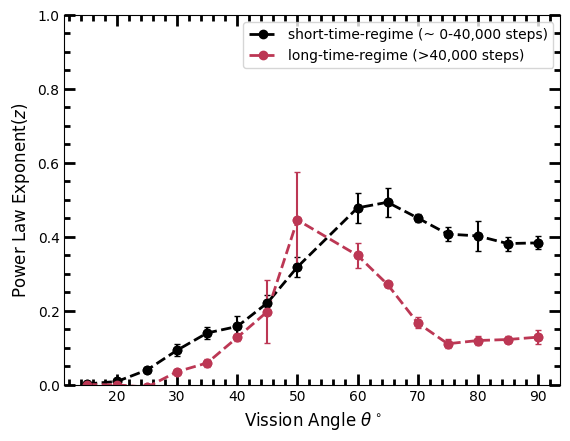

In [59]:
# Load the data from the text file
with open(parentFolder+'/TCDfit.txt', 'r') as f:
    Plot_Data_loaded = json.load(f)

# Convert the data to lists
thetalist_loaded = [float(key) for key in Plot_Data_loaded.keys()]
powerlist_loaded = [value[0] for value in Plot_Data_loaded.values()]
errorlist_loaded = [value[1] for value in Plot_Data_loaded.values()]
powerlist_loaded2 = [value[2] for value in Plot_Data_loaded.values()]
errorlist_loaded2 = [value[3] for value in Plot_Data_loaded.values()]

# plt.figure(figsize=(8, 6))   # Adjust figure size as needed
plt.plot(thetalist_loaded, powerlist_loaded,color="black", marker='o', linestyle='--', linewidth=2, label='short-time-regime (~ 0-40,000 steps)')
plt.plot(thetalist_loaded, powerlist_loaded2,color=cmap(1/2), marker='o', linestyle='--', linewidth=2, label='long-time-regime (>40,000 steps)')
plt.errorbar(thetalist_loaded, powerlist_loaded, yerr=errorlist_loaded, fmt='o', color="black", capsize=2)
plt.errorbar(thetalist_loaded, powerlist_loaded2, yerr=errorlist_loaded2, fmt='o', color=cmap(1/2), capsize=2)
plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
plt.minorticks_on()

plt.legend()
plt.xlabel('Vission Angle $\\theta^\\circ$', fontsize=12)
plt.ylabel('Power Law Exponent($z$)', fontsize=12)
plt.ylim(0, 1)
# plt.title('Cluster Growth Power law')
plt.savefig(parentFolder+'/cluster_growth_power_law_hva.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')
plt.show()

### Density based Cluster Growth Rate Comprison

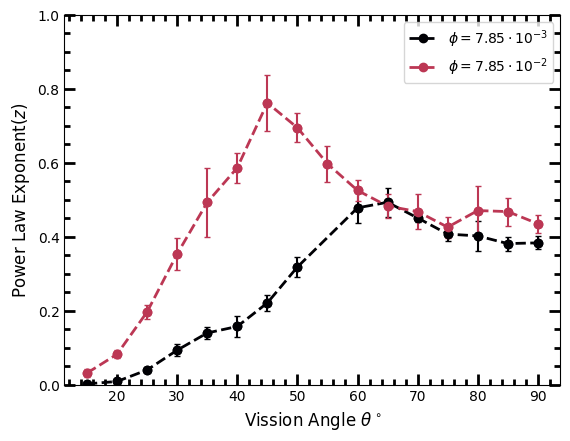

In [60]:
parent_folder_list = [r"Runs\Low Density\CRun", r"Runs\Mid Density\CRun"]
legend_list = ["$\\phi = 7.85 \\cdot 10^{-3}$", "$\\phi = 7.85 \\cdot 10^{-2}$",]
#load '/TCDfit.txt' from each parent folder
i=0
for parentFolder in parent_folder_list:
    with open(parentFolder+'/TCDfit.txt', 'r') as f:
        Plot_Data_loaded = json.load(f)

    # Convert the data to lists
    thetalist_loaded = [float(key) for key in Plot_Data_loaded.keys()]
    powerlist_loaded = [value[0] for value in Plot_Data_loaded.values()]
    errorlist_loaded = [value[1] for value in Plot_Data_loaded.values()]

    # plt.figure(figsize=(8, 6))   # Adjust figure size as needed
    plt.plot(thetalist_loaded, powerlist_loaded,color=cmap(i/2), marker='o', linestyle='--', linewidth=2, label=legend_list[i])
    plt.errorbar(thetalist_loaded, powerlist_loaded, yerr=errorlist_loaded, fmt='o', color=cmap(i/2), capsize=2)
    plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
    plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
    plt.minorticks_on()

    # plt.legend()
    plt.xlabel('Vission Angle $\\theta^\\circ$', fontsize=12)
    plt.ylabel('Power Law Exponent($z$)', fontsize=12)
    plt.ylim(0, 1)
    plt.legend()
    # plt.title('Cluster Growth Power law')
    plt.savefig(parentFolder+'/cluster_growth_power_law2.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')
    i+=1
plt.show()

## Rotational Analysis

In [25]:
def simAM(filePaths):
    all_angular_momenta_list = []
    all_time_list = []

    for file_path in tqdm(filePaths):
        data = load_data(file_path)
        particleData = np.array(data)

        variable_dict=save_param(file_path)
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])
        boxSize=float(variable_dict["boxSize"])

        simulation_data = particleData[:, :, 2:4]
        simulation_data = np.concatenate((simulation_data, np.zeros((simulation_data.shape[0], simulation_data.shape[1], 1))), axis=2)
        velocities = calculate_velocities(simulation_data, timestep, dataCompression, boxSize)

        all_angular_momenta, time=temporal_AM_distribution(simulation_data, velocities, rcut, min_samples, boxSize)
        all_angular_momenta_list.append(all_angular_momenta)
        # all_angular_velocity, time=temporal_AV_distribution(simulation_data, velocities, rcut, min_samples)
        # all_angular_momenta_list.append(all_angular_velocity)
        all_time_list.append(time)
    return all_angular_momenta_list, all_time_list
all_angular_momenta_list,all_time_list=simAM(filePaths)

100%|██████████| 48/48 [16:48<00:00, 21.01s/it]


In [ ]:
for i, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])

    plt.figure(figsize=(8, 6))   # Adjust figure size as needed
    plt.scatter(all_time_list[i], all_angular_momenta_list[i],s=5, c='black')
    # plt.plot(all_time_list[i], all_angular_momenta_list[i], c='black')
    plt.xlabel("Time")
    # plt.xscale('log')
    # plt.xlim(0, 50)
    plt.ylabel("Average Angular Momentum")
    # plt.yscale('log')
    plt.ylim([0,50])
    plt.title("Average Angular Momentum over Time, Theta = " + str(theta))
    plt.grid(True)
    plt.savefig(file_path+'/angular_momentum.png')
    # plt.show()
    # plt.close()

In [ ]:
# Calculate the mean angular momentum for each simulation
thetalist = [float(save_param(file_path)["theta"]) for file_path in filePaths]
#remove the first 10% of the data from all_angular_momenta_list
all_angular_ma_list=[]
# Assuming all_angular_momenta_list is a numpy array
all_angular_ma_list = np.array([element[int(len(element)*0.1):] for element in all_angular_momenta_list])
mean_angular_momentum_list = np.mean(all_angular_ma_list, axis=1)
print(all_angular_momenta_list)
# If the angles are the same then average the angular momentum
mean_angular_momentum_dict = {}
for i, theta in enumerate(thetalist):
    if theta in mean_angular_momentum_dict:
        mean_angular_momentum_dict[theta].append(mean_angular_momentum_list[i])
    else:
        mean_angular_momentum_dict[theta] = [mean_angular_momentum_list[i]]
mean_angular_momentum_list = {theta: np.mean(momenta) for theta, momenta in mean_angular_momentum_dict.items()}

# Plot the mean angular momentum
plt.figure(figsize=(8, 6))   # Adjust figure size as needed
plt.plot(list(mean_angular_momentum_list.keys()), list(mean_angular_momentum_list.values()), color='black', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Vission Angle $\\theta^\\circ$', fontsize=12)
plt.ylabel('Average Angular Momentum', fontsize=12)
plt.grid()
plt.show()

In [ ]:
# plt.figure(figsize=(8, 6))   # Adjust figure size as needed
for i, file_path in enumerate(tqdm(filePaths)):
    variable_dict=save_param(file_path)
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])
    if i%3!=0: continue
    if  theta!=45.0 and theta!=55.0 and theta!=70.0 and theta!=80: continue


    popt, pcov = curve_fit(linear_fit, all_time_list[i][l:h], all_angular_momenta_list[i][l:h], p0=[100, 1])
    plt.plot(all_time_list[i], linear_fit(all_time_list[i], *popt), color = cmap(theta/90),linestyle='--', linewidth=2,label=f"$\\theta={theta}^\\circ$")
    # plt.plot(all_time_list[i], all_angular_momenta_list[i], c=cmap(theta/90), linestyle='-')
    plt.scatter(all_time_list[i], all_angular_momenta_list[i], c=cmap(theta/90), s=2)

    plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
    plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
    plt.minorticks_on()
    # plt.grid()
    plt.legend()
    plt.xlabel('$time$',fontsize=12)
    plt.xscale('log')
    # plt.xlim(50, None)

    plt.ylabel('AM',fontsize=12)
    plt.yscale('log')
    # plt.title('Average Cluster Size as a Function of Time, Theta = ' + str(theta))
    plt.savefig(parentFolder+'/angular_momenta_distribution.png', dpi=600, bbox_inches='tight', facecolor='w', edgecolor='b')

plt.show()